In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
corpus = pd.read_csv('data/UNGDC_1946-2022.csv')
corpus

,year,session,country,country_name,speaker,post,text
0,1946,1,ARG,Argentina,Mr. Arce,NaN,At the resumption of the first session of the ...
1,1946,1,AUS,Australia,Mr. Makin,NaN,The General Assembly of the United Nations is ...
2,1946,1,BEL,Belgium,Mr. Van Langenhove,NaN,The\tprincipal organs of the United Nations ha...
3,1946,1,BLR,Byelorussian Soviet Socialist Republic,Mr. Kiselev,NaN,As more than a year has elapsed since the Unit...
4,1946,1,BOL,Bolivia,Mr. Costa du Rels,NaN,Coming to this platform where so many distingu...
...,...,...,...,...,...,...,...
10580,2022,77,WSM,Samoa,Fiame Naomi Mataafa,Prime Minister,I extend Samoa’s congratulations to His Excell...
10581,2022,77,YEM,Yemen,Rashad Mohammed Al-Alimi,President,"At the outset, I would like to sincerely congr..."
10582,2022,77,ZAF,South Africa,Naledi Pandor,Minister of Foreign Affairs,Allow me to join all speakers before me in con...
10583,2022,77,ZMB,Zambia,Hakainde Hichilema,President,"At the outset, we would like to congratulate M..."


In [60]:
corpus['length'] = corpus['text'].str.len()
corpus.describe().T  # '.T' method transposes the result to switch rows/columns

,count,mean,std,min,25%,50%,75%,max
year,10585.0,1992.145772,19.724731,1946.0,1977.0,1995.0,2009.0,2022.0
session,10585.0,47.145772,19.724731,1.0,32.0,50.0,64.0,77.0
length,10585.0,18405.266793,9367.997412,2362.0,11973.0,16373.0,22826.0,127150.0


In [61]:
corpus[['country', 'speaker']].describe().T

,count,unique,top,freq
country,10585,201,RUS,79
speaker,10500,7341,Sheikh Hasina,15


#### Checking for Missing Data
By looking at the counts in the previous table, we can see that the ```speaker``` column has missing values.

In [62]:
corpus.isna().sum()

year               0
session            0
country            0
country_name      83
speaker           85
post            4694
text               0
length             0
dtype: int64

In [66]:
corpus['speaker'] = corpus['speaker'].fillna('unknown')
corpus[corpus['speaker'].str.contains('Putin')]['speaker'].value_counts()

speaker
Vladimir V. Putin     1
Vladimir Putin        1
Mr. Vladimir Putin    1
Name: count, dtype: int64

#### Plotting Value Distributions
One way to visualize the <b>five-number summary</b> of a numerical distribution is a box plot (https://en.wikipedia.org/wiki/Box_plot).

<Axes: >

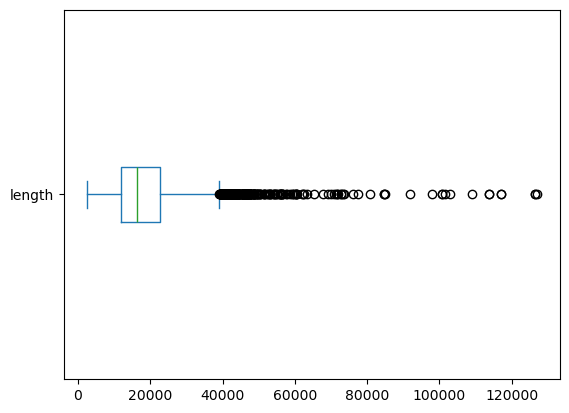

In [71]:
corpus['length'].plot(kind='box', vert=False)

As illustrated by this plot, 50% percent of the speeches (the box in the middle) have a length between roughly 12,000 and 23,000 characters, with the median at about 16,000 and a long tail with many outliers to the right. The distribution is obviously left-skewed.

We can get some more details by plotting a histogram: 

<Axes: ylabel='Frequency'>

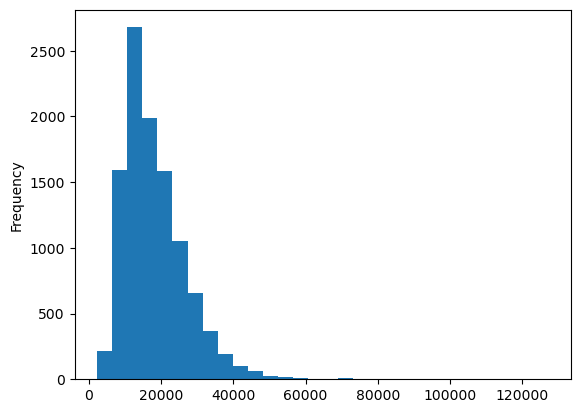

In [72]:
corpus['length'].plot(kind='hist', bins=30)

#### Comparing Value Distributions Across Categories
Peculiarities in the data often become visible when different subsets of the data are examined. 
A nice visualization to compare distributions across different categories is Seaborn's ```catplot``` (https://oreil.ly/jhlEE)

We show box and violin plots to compare the distributions of the speech length of the five permanent members of the UN Security Counsel. Thus, the category for the x-axis of ```sns.catplot``` is country:

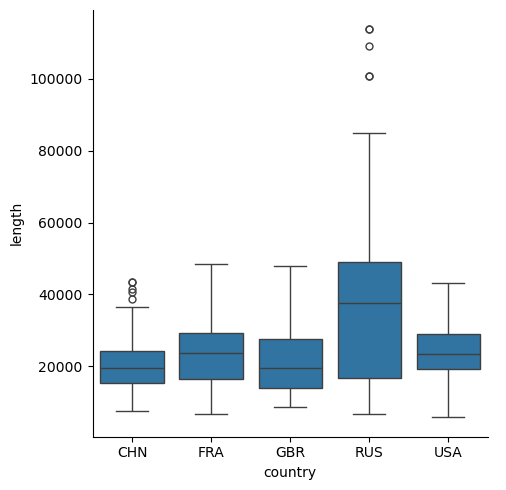

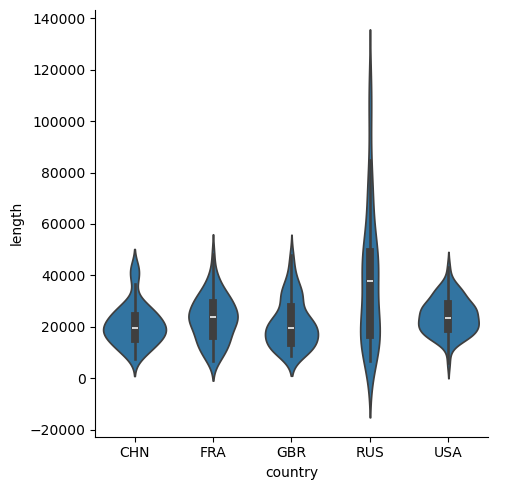

In [76]:
where = corpus['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])
sns.catplot(data=corpus[where], x='country', y='length', kind='box')
sns.catplot(data=corpus[where], x='country', y='length', kind='violin')

 Developments The violin plot is the "smoothed" version of a box plot. Frequencies are visualized by the width of the violin body, while the box is still visible inside the violin.

Both plots reveal that the dispersion of values, in this case the length of the speeches, for Russia is much larger than for Great Britian. But the existence of multiple peaks, as in Russia, only becomes appearant in the violin plot.

#### Visualizing Developments Over Time
A first time series can be created by analyzing the number of speeches per year. We can use the Pandas grouping function ```size()``` to return the number of rows per group. By simply appending ```plot()```, we can visualize the resulting ```DataFrame```.

<Axes: title={'center': 'Number of Countries'}, xlabel='year'>

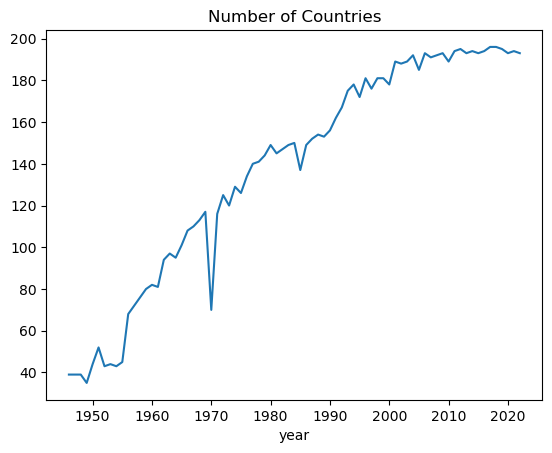

In [77]:
corpus.groupby('year').size().plot(title='Number of Countries')

The timeline reflects the development of the number of countries in the UN, as each country is eligible for only one speech per year. Actually, the UN has 193 members today. Interestingly, the speech length needed to decrease with more countries entering the debates, as the following analysis reveals:

<Axes: title={'center': 'Avg Speech Length'}, xlabel='year'>

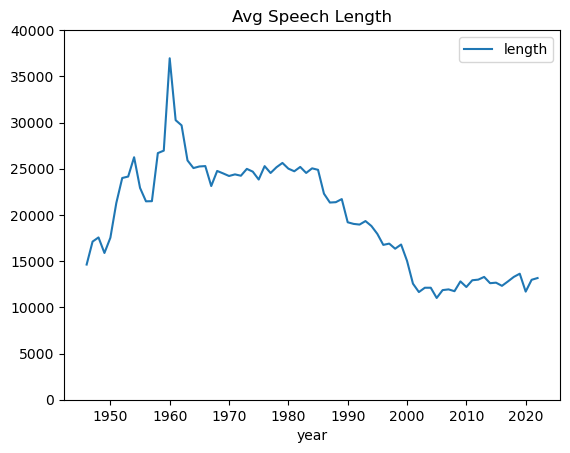

In [79]:
corpus.groupby('year').agg({'length': 'mean'}).plot(title='Avg Speech Length', ylim=(0, 40000))

<i>Pandas dataframes not only can be easily visualized in Jupyter notebooks but also can be exported to Excel (.xlsx), HTML, CSV, LaTeX, and many other formats by built-in functions. There is even a</i> ```to_clipboard()``` <i>function.</i>

Check the documentation (https://oreil.ly/HZDVN) for details.

#### Performing Tokenization with Regular Expressions

<i>Tokenization</i> is the process of extracting words from a sequence of characters. In Western languages, words are often separated by whitespaces and punctuation characters. Thus, the simplest and fastest tokenizer is Python’s native ```str.split()``` method, which splits on whitespace. A more flexible way is to use regular expressions.

Here, we want to apply a simple pattern that matches words. Words in our definition consist of at least one letter as well as digits and hyphens. Pure numbers are skipped because they almost exclusively represent dates or speech or session identifiers in this corpus.

The frequently used expression ```[A-Za-z]``` is not a good option for matching letters because it misses accented letters like ```ä``` or ```â```. Much better is the POSIX character class ```\p{L}```, which selects all Unicode letters. 

Note that we need the ```regex``` library (https://oreil.ly/hJ6M2) instead of ```re``` to work with POSIX character classes. 

The following expression matches tokens consisting of at least one letter (```\p{L}```), preceded and followed by an arbitrary sequence of alphanumeric characters (```\w``` includes digits, letters, and underscore) and hyphens (-):

In [81]:
import regex as re

def tokenize(text):
    return re.findall(r'[\w+]*\p{L}[\w]*', text)

In [82]:
text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print("|".join(tokens))

Let|s|defeat|SARS|CoV|together|in


#### Treating Stop Words

The most frequent words in text are common words such as determiners, auxiliary verbs, pronouns, adverbs, and so on. These words are called stop words. Stop words usually don’t carry much information but hide interesting content because of their high frequencies. Therefore, stop words are often removed before data analysis or model training.

Common stop word lists are available for many languages and are integrated in almost any NLP library. We will work with NLTK’s list of stop words here, but you could use almost any list of words as a filter (you can address spaCy’s list similarly with ```spacy.lang.en.STOP_WORDS```).

For fast lookup, you should always convert a list to a set. Sets are hash-based structures like dictionaries with nearly constant lookup time:

In [90]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ethan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Our approach to remove stop words from a given list , wrapped into the small function shown here, consists of a simple list comprehension. For the check, tokens are converted to lowercase as NLTK’s list contains only lowercase words:

In [89]:
stop_words = set(stopwords.words('english'))

def remove_stop_words(tokens):
    return [t for t in tokens if t.lower() not in stop_words]

Often you’ll need to add domain-specific stop words to the predefined list. For example, if you are analyzing emails, the terms <i>dear</i> and <i>regards</i> will probably appear in almost every document.

On the other hand, you might want to treat some of the words in the predefined list not as stop words. We can add additional stop words and exclude others from the list using two of Python’s set operators, ```|``` (union/or) and ```-``` (difference):

In [92]:
include_stop_words = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stop_words = {'against'}

stop_words |= include_stop_words
stop_words -= exclude_stop_words

#### Processing a Pipeline with One Line of Code
Let's